In [1]:
import copy
import warnings
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from PIL import Image
from fuzzywuzzy import fuzz
from matplotlib.colors import LogNorm
from wordcloud import WordCloud, STOPWORDS

# Ignore FutureWarning for plt part
warnings.filterwarnings("ignore", category=FutureWarning)

# Ignore specific UserWarning from fuzzywuzzy.fuzz
warnings.filterwarnings("ignore", category=UserWarning, 
                        message='Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning', 
                        module='fuzzywuzzy.fuzz')

C:\Users\vdebl\anaconda3\envs\ada\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## 1. Data Preprocessing

Dataset: Beer Reviews 

![image]()

In [2]:
# Load data
rb = pd.read_csv(".\\matched_beer_data\\ratings_with_text_rb.csv", sep = ",", header = 0)
ba = pd.read_csv(".\\matched_beer_data\\ratings_with_text_ba.csv", sep = ",", header = 0)

### 1.1 Delete Missing Values

Drop the rows with empty 'text'

In [3]:
ba_no_duplicates = ba.copy().drop_duplicates() 
ba_filtered = ba_no_duplicates.dropna(subset=['text'], how='all')

rb_no_duplicates = rb.copy().drop_duplicates()
rb_filtered = rb_no_duplicates.dropna(subset=['text'], how='all')

Calculate the number of reviews for each beer, and check the distribution of the number of reviews for different beers.

In [4]:
# Check distribution for ba
ba_filtered_counts = ba_filtered['beer_id'].value_counts()
ba_filtered_counts = pd.DataFrame(data = ba_filtered_counts)
print(ba_filtered_counts.describe())

              count
count  28271.000000
mean      10.223126
std       53.640052
min        1.000000
25%        1.000000
50%        2.000000
75%        5.000000
max     2968.000000


In [5]:
#Check reviews distribution for rb
rb_filtered_counts = rb_filtered['beer_id'].value_counts()
rb_filtered_counts = pd.DataFrame(data = rb_filtered_counts)
print(rb_filtered_counts.describe())

              count
count  42228.000000
mean      24.168632
std       83.010641
min        1.000000
25%        2.000000
50%        5.000000
75%       18.000000
max     5270.000000


### 1.2 Data Filtering

- Eliminate entries for beers that have fewer than two reviews before conducting sentiment analysis. 

Data from "RateBeer" shows that 75% of the beers have more than two reviews. In contrast, "BeerAdvocate" data indicates that while 75% of beers have more than one review, only half have more than two reviews. We've chosen a minimum of two reviews as our cutoff point. Analyzing sentiment for beers with a low number of reviews could introduce a significant bias, hence the decision for this threshold.

In [6]:
# Counting the number of beers from BeerAdvocate
ba_filtered_counts = ba_filtered['beer_id'].value_counts()

# Eliminate entries for beers that have fewer than two reviews
beers_to_keep = ba_filtered_counts[ba_filtered_counts >= 2].index
mask = ba_filtered['beer_id'].isin(beers_to_keep)
filtered_data_ba = ba_filtered[mask]

# Counting the number of beers from RateBeer
rb_filtered_counts = rb_filtered['beer_id'].value_counts()

# Eliminate entries for beers that have fewer than two reviews
beers_to_keep = rb_filtered_counts[rb_filtered_counts >= 2].index
mask = rb_filtered['beer_id'].isin(beers_to_keep)
filtered_data_rb = rb_filtered[mask]

## 2. Descriptive Statistical Analysis and Visualization

### 2.1 Descriptive Statistical Analysis

### 2.2 Data Visualization

#### 2.2.1 Beer Review

The distribution of the number of reviews per beer is expected to be heavy-tailed. Indeed, a few beers are expected to be very popular and represent a large share of the total number of reviews, thus skewing the distribution towards higher values. 

The figure below shows the cumulative distribution of review counts per beer:

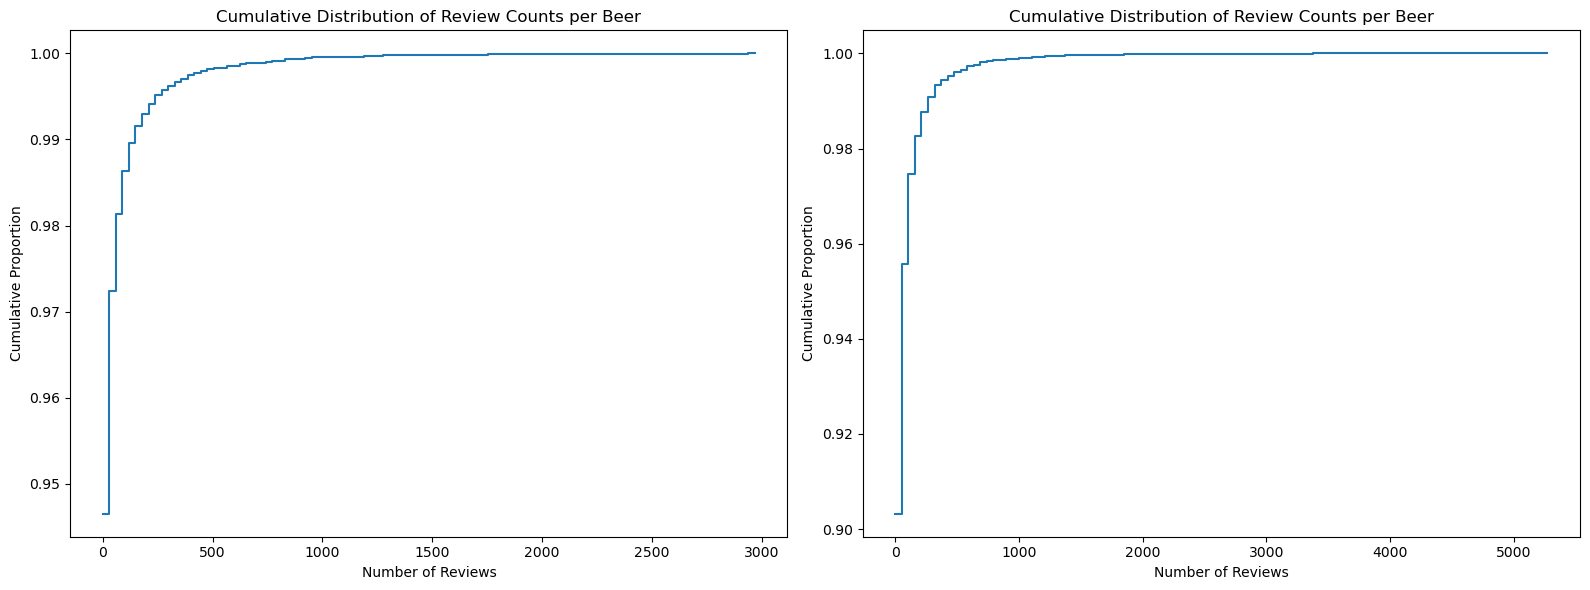

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Cumulative Distribution Plot (BA)
sns.histplot(ax=axes[0], data=ba_filtered_counts, bins=100, cumulative=True, stat="density", element="step", fill=False)
axes[0].set_title("Cumulative Distribution of Review Counts per Beer")
axes[0].set_xlabel("Number of Reviews")
axes[0].set_ylabel("Cumulative Proportion")

# Cumulative Distribution Plot (RB) 
sns.histplot(ax=axes[1], data=rb_filtered_counts, bins=100, cumulative=True, stat="density", element="step", fill=False)
axes[1].set_title("Cumulative Distribution of Review Counts per Beer")
axes[1].set_xlabel("Number of Reviews")
axes[1].set_ylabel("Cumulative Proportion")

plt.tight_layout() 
plt.show()

Here we can see that the cumulative proportion almost immediately jumps to very high cumulative proportions. This means that the data could be heay-tailed. The following figure shows the same information, but with the x-axis in logarithmic scale:

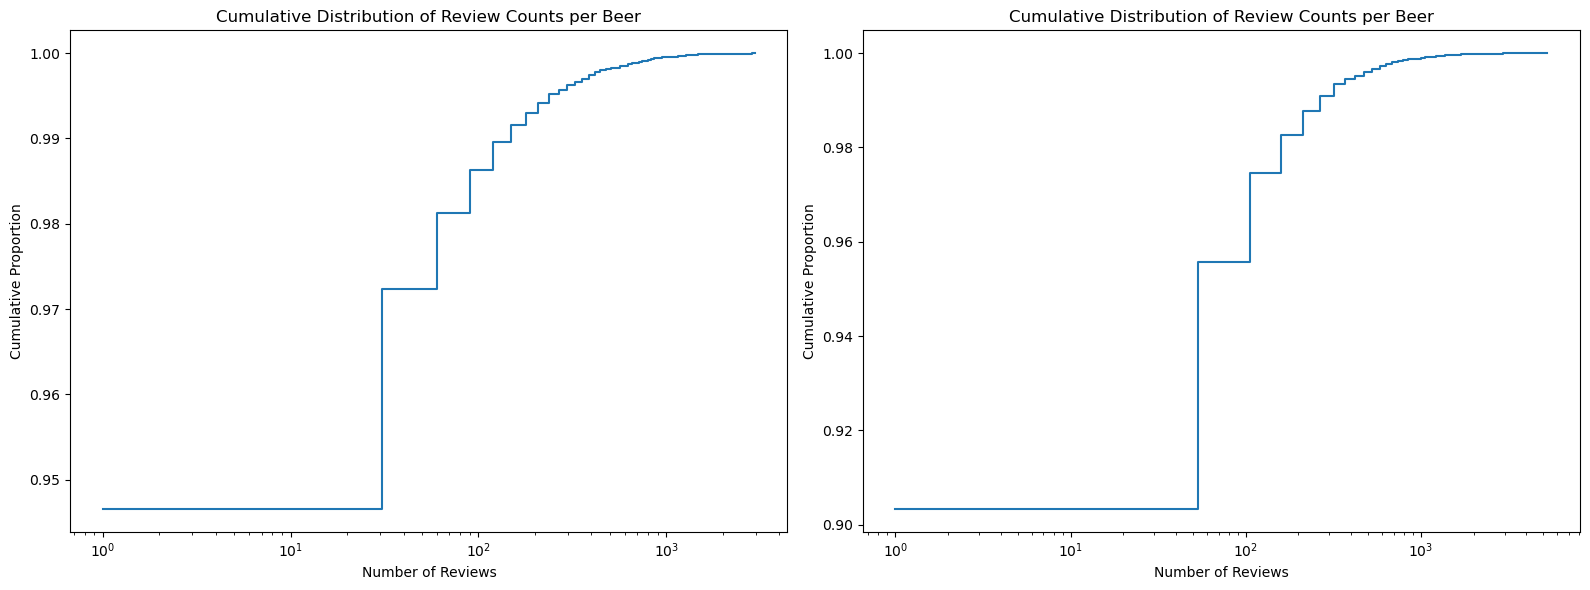

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Cumulative Distribution Plot (BA) with log x-axis
sns.histplot(ax=axes[0], data=ba_filtered_counts, bins=100, cumulative=True, stat="density", element="step", fill=False)
axes[0].set_title("Cumulative Distribution of Review Counts per Beer")
axes[0].set_xlabel("Number of Reviews")
axes[0].set_ylabel("Cumulative Proportion")
axes[0].set_xscale('log')

# Cumulative Distribution Plot (RB) with log x-axis
sns.histplot(ax=axes[1], data=rb_filtered_counts, bins=100, cumulative=True, stat="density", element="step", fill=False)
axes[1].set_title("Cumulative Distribution of Review Counts per Beer")
axes[1].set_xlabel("Number of Reviews")
axes[1].set_ylabel("Cumulative Proportion")
axes[1].set_xscale('log') 

plt.tight_layout()
plt.show()

Here we can better visualize the wide distribution in review counts for both websites. The graphs show that a very small proportion of the beers have a very high number of reviews, while the majority show much lower values. 

In addition, the figure below shows the same information but with frequency as in the y-axis (in log scale). This shows that the large majority of beers have a numer of reviews in the order of a few hundreds.

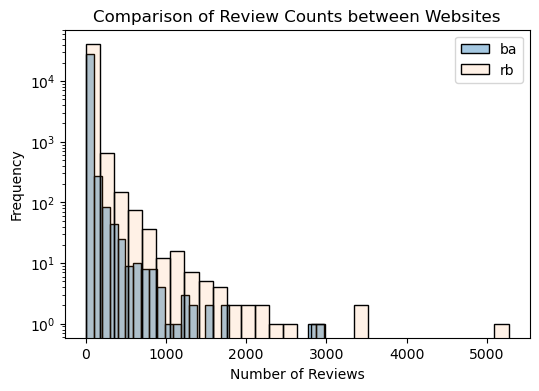

In [9]:
plt.figure(figsize=(6, 4))
sns.histplot(ba_filtered_counts, bins=30, label='ba',log_scale=(False, True), alpha=0.4)
sns.histplot(rb_filtered_counts, bins=30, label='rb',log_scale=(False, True), alpha=0.1)

plt.title('Comparison of Review Counts between Websites')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Here we will dive into the popularity of the different styles of beer present in our dataset.

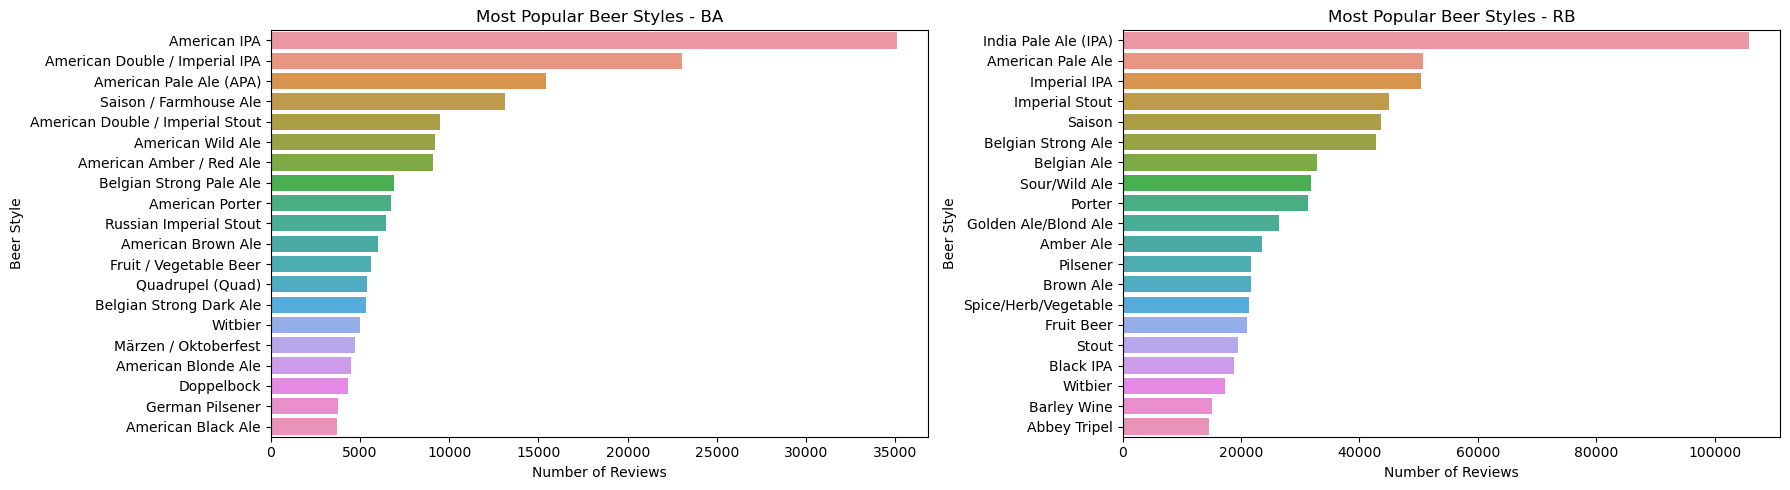

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Aggregate review counts by beer style for BA
style_counts_ba = ba_filtered['style'].value_counts()

# Select the top N styles for visualization
# Adjust the number (e.g., 20) to display more or fewer styles
top_styles_ba = style_counts_ba.head(20)
sns.barplot(ax=axes[0], x=top_styles_ba.values, y=top_styles_ba.index)
axes[0].set_title('Most Popular Beer Styles - BA')
axes[0].set_xlabel('Number of Reviews')
axes[0].set_ylabel('Beer Style')


# Aggregate review counts by beer style for RB
style_counts_rb = rb_filtered['style'].value_counts()

# Select the top N styles for visualization
# Adjust the number (e.g., 20) to display more or fewer styles
top_styles_rb = style_counts_rb.head(20)
sns.barplot(ax=axes[1], x=top_styles_rb.values, y=top_styles_rb.index)
axes[1].set_title('Most Popular Beer Styles - RB')
axes[1].set_xlabel('Number of Reviews')
axes[1].set_ylabel('Beer Style')

plt.tight_layout() 
plt.show()

The horizontal bar chart provides a clear depiction of the popularity of various beer styles based on the volume of reviews received. 

The data suggests a strong preference for American IPAs and Indian Pale Ale (IPA), which lead with the highest number of reviews for each website, respectively. Following are American Double and Imperial IPAs, and American Pale Ales, indicating a favorability towards hop-rich beer types. The chart includes a variety of international beer styles, such as Belgian Strong Pale Ale and German Pilsener, showcasing a range of tastes among reviewers. The information could be valuable for understanding consumer trends and preferences in the beer market. Overall, this chart is a straightforward visual tool for assessing the popularity of beer styles in a comparative manner.


#### 2.2.2 User Data

We will now have a look at the users and the location of the reviews.

In [11]:
file_path = '.\\matched_beer_data\\users.csv'  
df = pd.read_csv(file_path)
df = df.drop(df.index[0])

In [12]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

location = []
for item1 in df['rb.1'].values:
    closest_match = None
    highest_similarity = 0
    for item2 in world['name'].values:
        similarity = fuzz.ratio(item1, item2)
        if similarity > highest_similarity:
            closest_match = item2
            highest_similarity = similarity
    location.append(closest_match)
    
df['location'] = location
print(df['location'] )

1                        Germany
2       United States of America
3       United States of America
4                        Estonia
5                        Finland
                  ...           
3016    United States of America
3017    United States of America
3018    United States of America
3019                     Vietnam
3020                      Sweden
Name: location, Length: 3020, dtype: object


In [13]:
# Getting unique values and their counts
unique_values = df['location'].unique()
user_counts = df['location'].value_counts().reset_index()
user_counts.columns = ['country', 'count']

print(unique_values)

['Germany' 'United States of America' 'Estonia' 'Finland' 'Spain'
 'Netherlands' 'Belarus' 'Switzerland' 'Canada' 'Poland' 'Norway' 'Sweden'
 'Mexico' 'Czechia' 'Slovenia' 'Belgium' 'Thailand' 'Australia' 'Malaysia'
 'Greece' 'Russia' 'El Salvador' 'Denmark' 'Croatia' 'Moldova' 'Brazil'
 'Uruguay' 'Austria' 'Italy' 'Turkey' 'South Africa' 'Peru' 'Romania'
 'Bulgaria' 'Hungary' 'Lithuania' 'Philippines' 'France' 'Puerto Rico'
 'Argentina' 'Suriname' 'Portugal' 'Mauritania' 'Taiwan' 'Japan' 'Ukraine'
 'Panama' 'Paraguay' 'Israel' 'Serbia' 'Belize' 'Ireland' 'China' 'India'
 'Lebanon' 'Chile' 'Vietnam']


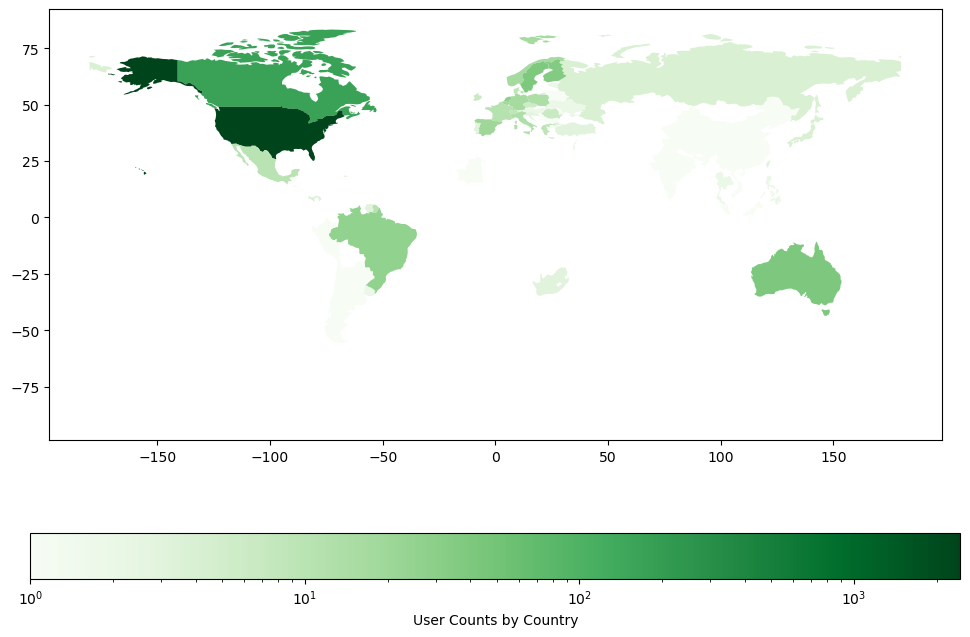

In [14]:
# Merge world map data and user count data
# Adding suffixes to handle overlapping column names
world = world.merge(user_counts, how='left', left_on='name', right_on='country', suffixes=('', '_user'))

# If 'country_user' is the name of the overlapping column, use it. Otherwise, use 'country'.
if 'country_user' in world.columns:
    user_country_column = 'country_user'
else:
    user_country_column = 'country'

# Set regions with NaN number of users to 0
world['count'] = world['count'].fillna(0)

# Draw map with logarithmic scale for coloring
norm = LogNorm(vmin=world['count'].min() + 1, vmax=world['count'].max())
world.plot(column='count', cmap='Greens', figsize=(12, 8), legend=True,
           norm=norm,  # Apply log scale
           legend_kwds={'label': "User Counts by Country",
                        'orientation': "horizontal"})

plt.show()

From such a map we can see that a vast majority of users are from the United scales, followed by Canada. The log scale allows for a better visualization of the other countries showing a number of users orders of magnitude lower. 

#### 2.2.3 Review Data

- Beer Ratings

C:\Users\vdebl\AppData\Local\Temp\ipykernel_13676\2608404297.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ba_filtered.loc[:, 'source'] = 'BeerAdvocate'
C:\Users\vdebl\AppData\Local\Temp\ipykernel_13676\2608404297.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rb_filtered.loc[:, 'source'] = 'RateBeer'


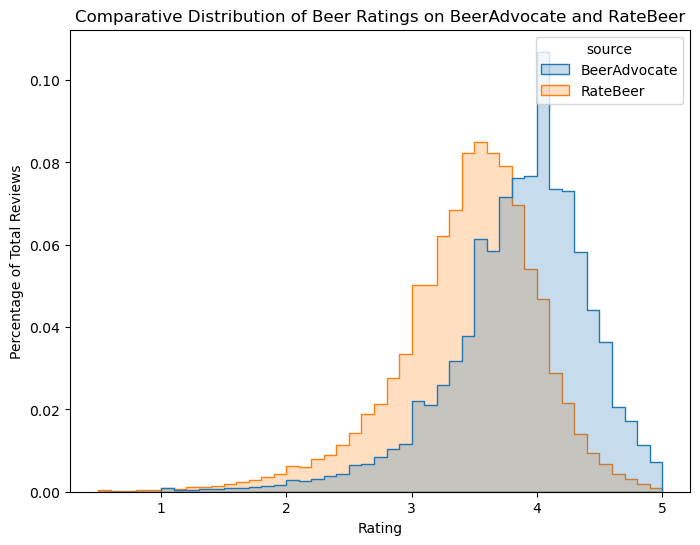

In [15]:
ba_filtered.loc[:, 'source'] = 'BeerAdvocate'
rb_filtered.loc[:, 'source'] = 'RateBeer'
all_reviews = pd.concat([ba_filtered, rb_filtered], ignore_index=True)

plt.figure(figsize=(8, 6))
sns.histplot(data=all_reviews[['rating', 'source']], 
             x='rating', hue='source', 
             element='step', stat='probability', 
             common_norm=False, binwidth=0.1)
plt.title("Comparative Distribution of Beer Ratings on BeerAdvocate and RateBeer")
plt.xlabel("Rating")
plt.ylabel("Percentage of Total Reviews")
plt.show()

This figure plots the histograms of ratings for both websites. We can clearly see that users on BeerAdvocate tend to give higher ratings than users on RateBeer. In this figure, the distribution of ratings deviates from the commonly observed bimodal pattern on various rating websites, characterized by clusters of very high or very low values, often attributed to the "brag-and-moan" phenomenon. Instead, the ratings for beer styles depicted here appear to be more evenly distributed, suggesting that beer rating websites may experience a lower degree of selection bias driven by extreme satisfaction or dissatisfaction.

To enable meaningful comparisons of ratings across different websites and timeframes, it's necessary to adjust for biases caused by site-specific rating tendencies (such as shifted distributions of ratings) and changes over time in these tendencies (evidenced by changing averages and decreasing variances). Rather than using raw ratings, we utilize normalized ratings, or z-scores. 

Source : Lederrey, G., & West, R. (2018). When Sheep Shop: Measuring Herding Effects in Product Ratings with Natural Experiments. Proceedings of the 2018 World Wide Web Conference, 793–802. https://doi.org/10.1145/3178876.3186160


- Beer Ratings(standardization)

In [16]:
# Rating standerlization for filtered_data_ba.
mean_rating = ba_filtered['rating'].mean()
std_rating = ba_filtered['rating'].std()
# Standardize the 'ratings' column
ba_filtered.loc[:, 'standardized_ratings'] = (ba_filtered['rating'] - mean_rating) / std_rating

# Rating standerlization for filtered_data_rb.
mean_rating = rb_filtered['rating'].mean()
std_rating = rb_filtered['rating'].std()
# Standardize the 'ratings' column
rb_filtered.loc[:, 'standardized_ratings'] = (rb_filtered['rating'] - mean_rating) / std_rating

C:\Users\vdebl\AppData\Local\Temp\ipykernel_13676\1667596477.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ba_filtered.loc[:, 'standardized_ratings'] = (ba_filtered['rating'] - mean_rating) / std_rating
C:\Users\vdebl\AppData\Local\Temp\ipykernel_13676\1667596477.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rb_filtered.loc[:, 'standardized_ratings'] = (rb_filtered['rating'] - mean_rating) / std_rating


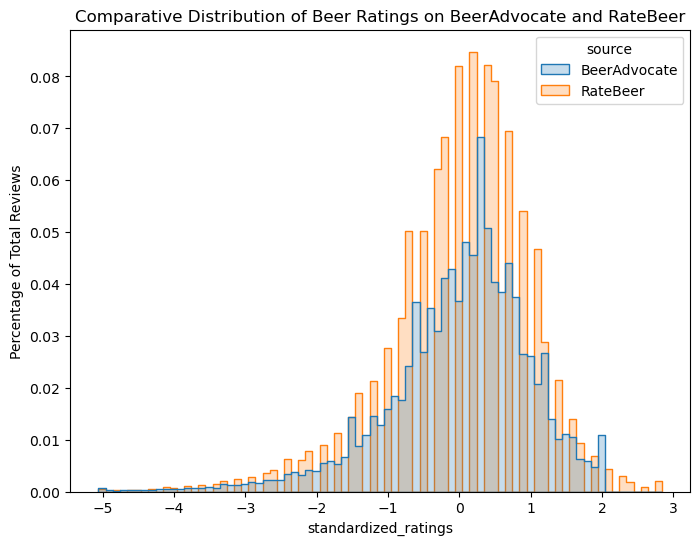

In [17]:
all_reviews_std = pd.concat([ba_filtered, rb_filtered], ignore_index=True)
plt.figure(figsize=(8, 6))
sns.histplot(data=all_reviews_std[['standardized_ratings', 'source']], 
             x='standardized_ratings', hue='source', 
             element='step', stat='probability', 
             common_norm=False, binwidth=0.1)
plt.title("Comparative Distribution of Beer Ratings on BeerAdvocate and RateBeer")
plt.xlabel("standardized_ratings")
plt.ylabel("Percentage of Total Reviews")
plt.show()

Following the standardization process, the rating distributions for the two websites now entirely overlap, allowing for direct comparison of ratings between sites. However, it's crucial to recognize that despite the standardized rating distributions being the same for both sites, individual products might still have significantly divergent ratings when compared between BeerAdvocate and RateBeer.

C:\Users\vdebl\AppData\Local\Temp\ipykernel_13676\2179498514.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ba_filtered.loc[:,'standardized_aroma'] = (ba_filtered['aroma'] - mean_aroma) / std_aroma
C:\Users\vdebl\AppData\Local\Temp\ipykernel_13676\2179498514.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rb_filtered.loc[:,'standardized_aroma'] = (rb_filtered['aroma'] - mean_aroma) / std_aroma
C:\Users\vdebl\AppData\Local\Temp\ipykernel_13676\2179498514.py:58: SettingWithCopyWarning: 
A value is 

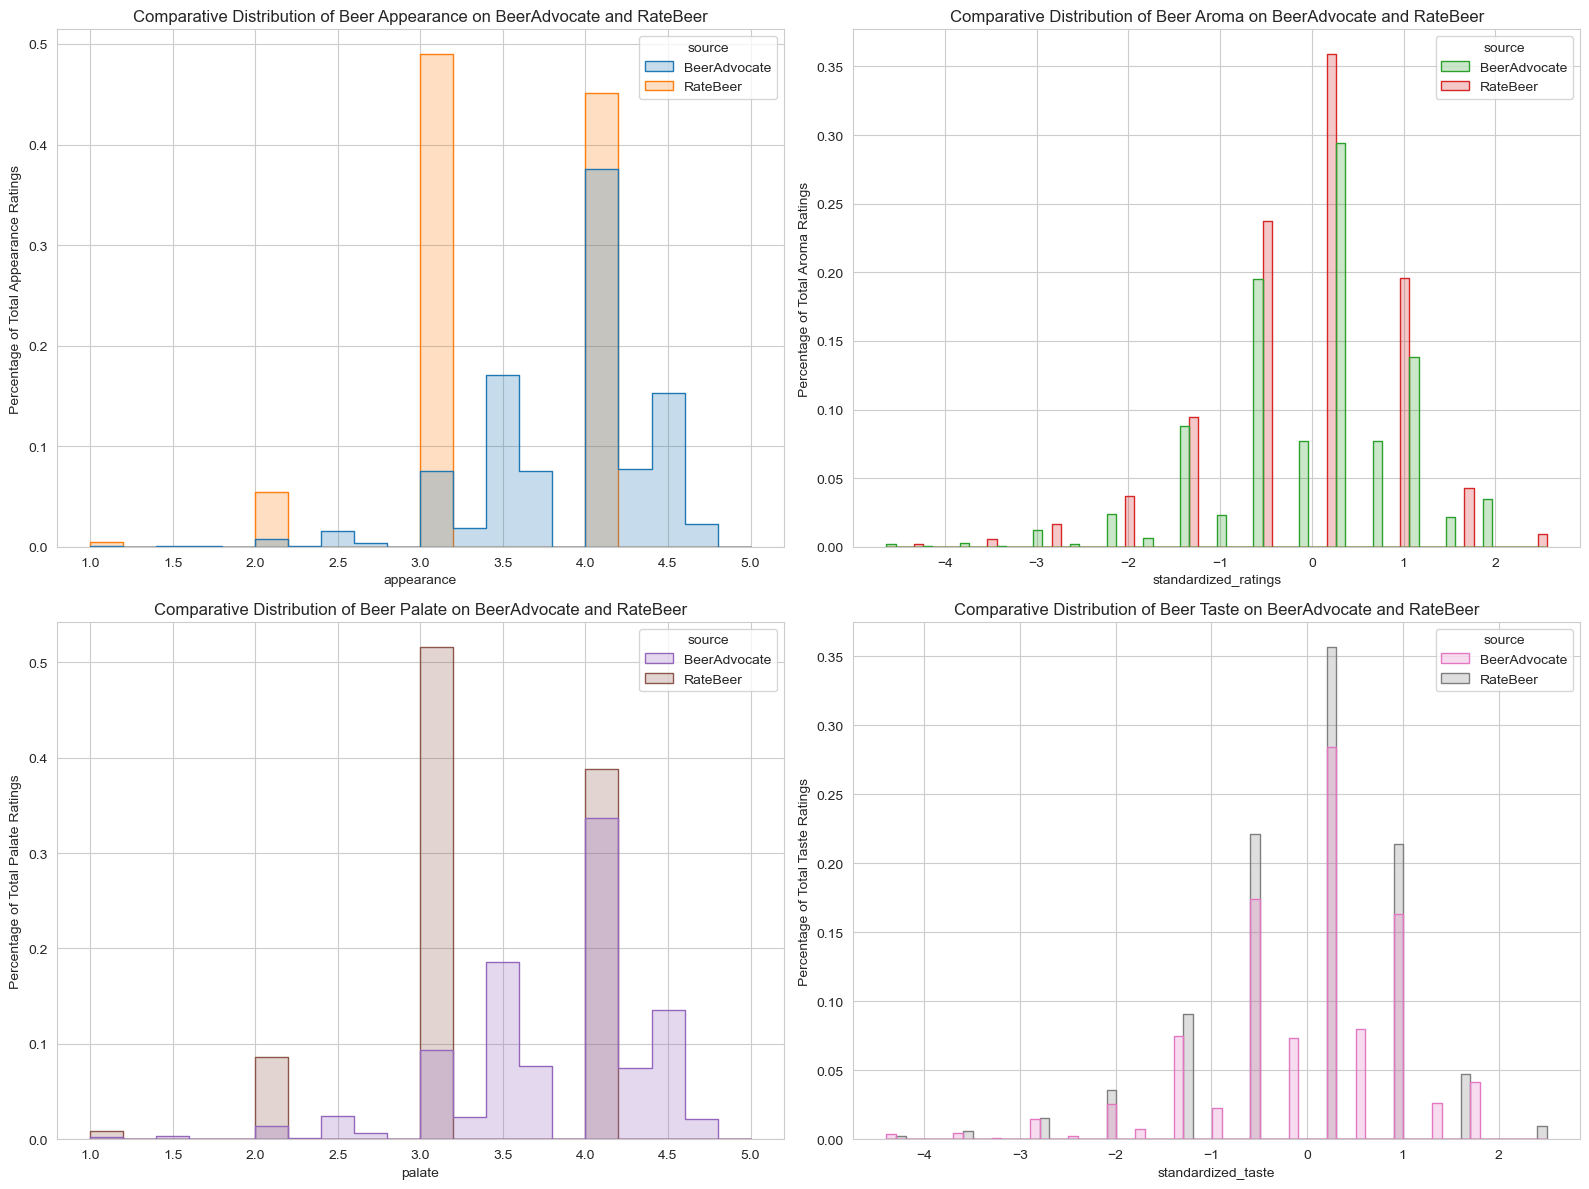

In [18]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Define four color groups, one for each subplot
palette1 = ["#1f77b4", "#ff7f0e"]  # taste
palette2 = ["#2ca02c", "#d62728"]  # palate
palette3 = ["#9467bd", "#8c564b"]  # aroma
palette4 = ["#e377c2", "#7f7f7f"]  # appearance

# 1) Appearance
sns.histplot(data=all_reviews[['appearance', 'source']], 
             x='appearance', hue='source', 
             element='step', stat='probability', 
             common_norm=False, binwidth=0.2, ax=axes[0, 0], palette=palette1)
axes[0, 0].set_title("Comparative Distribution of Beer Appearance on BeerAdvocate and RateBeer")
axes[0, 0].set_xlabel("appearance")
axes[0, 0].set_ylabel("Percentage of Total Appearance Ratings")


# 2) Aroma
# aroma standerlization for filtered_data_ba.
mean_aroma = ba_filtered['aroma'].mean()
std_aroma = ba_filtered['aroma'].std()

# Standardize the 'aroma' column
ba_filtered.loc[:,'standardized_aroma'] = (ba_filtered['aroma'] - mean_aroma) / std_aroma

# Rating standerlization for filtered_data_rb.
mean_aroma = rb_filtered['aroma'].mean()
std_aroma = rb_filtered['aroma'].std()
# Standardize the 'ratings' column
rb_filtered.loc[:,'standardized_aroma'] = (rb_filtered['aroma'] - mean_aroma) / std_aroma
all_aroma_std = pd.concat([ba_filtered, rb_filtered], ignore_index=True)

sns.histplot(data=all_aroma_std[['standardized_aroma', 'source']], 
             x='standardized_aroma', hue='source', 
             element='step', stat='probability', 
             common_norm=False, binwidth=0.1, ax=axes[0, 1], palette=palette2)
axes[0, 1].set_title("Comparative Distribution of Beer Aroma on BeerAdvocate and RateBeer")
axes[0, 1].set_xlabel("standardized_ratings")
axes[0, 1].set_ylabel("Percentage of Total Aroma Ratings")

# 3) Palate

sns.histplot(data=all_reviews[['palate', 'source']], 
             x='palate', hue='source', 
             element='step', stat='probability', 
             common_norm=False, binwidth=0.2, ax=axes[1, 0], palette=palette3)
axes[1, 0].set_title("Comparative Distribution of Beer Palate on BeerAdvocate and RateBeer")
axes[1, 0].set_xlabel("palate")
axes[1, 0].set_ylabel("Percentage of Total Palate Ratings")

# 4) Taste
# taste standerlization for filtered_data_ba.
mean_taste = ba_filtered['taste'].mean()
std_taste = ba_filtered['taste'].std()
# Standardize the 'taste' column
ba_filtered.loc[:, 'standardized_taste'] = (ba_filtered['taste'] - mean_taste) / std_taste

# taste standerlization for filtered_data_rb.
mean_taste = rb_filtered['taste'].mean()
std_taste = rb_filtered['taste'].std()
# Standardize the 'taste' column
rb_filtered.loc[:,'standardized_taste'] = (rb_filtered['taste'] - mean_taste) / std_taste

all_taste_std = pd.concat([ba_filtered, rb_filtered], ignore_index=True)
sns.histplot(data=all_taste_std[['standardized_taste', 'source']], 
             x='standardized_taste', hue='source', 
             element='step', stat='probability', 
             common_norm=False, binwidth=0.1, ax=axes[1, 1], palette=palette4)
axes[1, 1].set_title("Comparative Distribution of Beer Taste on BeerAdvocate and RateBeer")
axes[1, 1].set_xlabel("standardized_taste")
axes[1, 1].set_ylabel("Percentage of Total Taste Ratings")

plt.tight_layout()
plt.show()

The subplots display the rating distributions for different beer characteristics, such as appearance, aroma, palate, and taste. Notably, the scales for these ratings are not uniform; RateBeer scores for aroma and palate go from 0 to 10, whereas all other attributes are scored between 0 and 5. This is the reason why these were standardized to enable a better comparison.

The granularity of the ratings also has a considerable impact on the distribution shapes. BeerAdvocate permits more detailed ratings with increments of 0.25, whereas RateBeer only allows whole number ratings. Observing the ratings for appearance and palate, it is evident that the majority fall at 3 or 4 on a 5-point scale. The more granular rating system on BeerAdvocate results in a higher concentration of ratings near the upper limit.


We will now look at the textual content of the reviews, representing the distribution of words used with wordclouds:

In [19]:
texts = filtered_data_ba['text']
#Add more personalized stopwords
additional_stopwords = {'beer', 'beers'}
stopwords = set(STOPWORDS).union(additional_stopwords)

In [20]:
%%time

beer_can_image = 'C:\\Users\\ROG\\Desktop\\VK750.jpg'
mask = np.array(Image.open(beer_can_image))


wordcloud = WordCloud(
    width = 800, height = 800, 
    background_color ='white', 
    stopwords = stopwords, 
    min_font_size = 10,
)

wordcloud.generate(' '.join(texts))

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\ROG\\Desktop\\VK750.jpg'

RateBeer : 
The word cloud from RateBeer website centers around key attributes such as "head", "malt", "taste", "aroma", "body", "bitter", and "sweet". These larger words indicate that they are frequently mentioned in the dataset. The prominence of "head" suggests a focus on the foam's quality, while "malt" and "bitter" point to specific taste characteristics that are often evaluated. "Body" refers to the texture or mouthfeel of the beer, and "aroma" highlights the importance of smell in the drinking experience. The word "medium" might relate to the intensity or balance of flavors. Visual descriptors such as "dark", "golden", "amber", and "white" are evident, indicating that color and clarity are also noted in reviews but perhaps with less frequency than taste and aroma. 


In [21]:
%%time

beer_can_image = '..\\Desktop\\VK750.jpg'
mask = np.array(Image.open(beer_can_image))


wordcloud = WordCloud(
    width = 800, height = 800, 
    background_color ='white', 
    stopwords = stopwords, 
    min_font_size = 10,
)

wordcloud.generate(' '.join(texts))*

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

SyntaxError: invalid syntax (<unknown>, line 12)

The word cloud above is from the other rating website, BeerAdvocate.  The most prominent words are "taste", "one", and "bit". These larger words indicate their significance and frequency in the reviews. "Taste" clearly is a focal point of discussion, suggesting that the flavor of the beer is a primary concern for reviewers. The word "one" might be part of various contexts, possibly referring to a singular aspect of the beer or its uniqueness. "Bit" could be used in reviews to describe a small amount or degree of a certain characteristic, such as "a bit hoppy" or "a bit bitter".

Other notable words that appear in medium to large sizes include "nose", which refers to the aroma, and "mouthfeel", indicating the texture of the beer as experienced in the mouth. "Good", "malt", "color", "body", "head", and "finish" are also significant, highlighting aspects like the beer's appearance, the foam's quality, and the aftertaste. The presence of "bit" in large letters also suggests that nuances in flavor or experience are often highlighted in reviews.


Overall, the word clouds presented above illustrate that beer reviews are multifaceted, with a focus on the sensory experience of aroma and taste, as well as the physical aspects of the beer.


In addition to this preliminary analysis, semantic similarity  scores were computed on a sample of the data. The details of those calculations in addition with the preliminary results are located in the other notebook of this repository, named 'Semantic_Similarity_Sample'.